# Data Importing

In [169]:
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
import joblib

from pandas_profiling import ProfileReport
from category_encoders import OrdinalEncoder

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [170]:
# Import data from root dir
data = pd.read_csv('../All_data_with_exits.csv')
df = pd.DataFrame(data)

# Set view options
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [171]:
print("Original CSV Shape: ", df.shape)
df.head()

Original CSV Shape:  (1862, 143)


,2.1 Organization Name,2.2 Project Name,2.4 ProjectType,2.5 Utilization Tracking Method (Invalid),2.6 Federal Grant Programs,5.8 Personal ID,5.9 Household ID,3.15 Relationship to HoH,3.16 Client Location,CaseMembers,3.10 Enroll Date,3.11 Exit Date,3.12 Exit Destination,3.2 Social Security Quality,3.3 Birthdate Quality,Age at Enrollment,Current Age,3.4 Race,3.5 Ethnicity,3.6 Gender,3.7 Veteran Status,3.8 Disabling Condition at Entry,3.917 Living Situation,3.917b Stayed Less Than 7 Nights,3.917 Stayed Less Than 90 Days,"3.917b Stayed in Streets, ES or SH Night Before",3.917 Length of Stay,3.917 Homeless Start Date,Length of Time Homeless (3.917 Approximate Start),3.917 Times Homeless Last 3 Years,3.917 Total Months Homeless Last 3 Years,V5 Last Permanent Address,V5 State,V5 Zip,Municipality (City or County),Days Enrolled in Project,RRH In Permanent Housing,RRH Date Of Move-In,Days Enrolled Until RRH Date of Move-in,4.1 Housing Status,4.4 Covered by Health Insurance,4.11 Domestic Violence,4.11 Domestic Violence - Currently Fleeing DV?,4.11 Domestic Violence - When it Occurred,4.13 Engagement Date,Days Enrolled Until Engagement Date,4.24 Current Status (Retired Data Element),4.24 In School (Retired Data Element),4.24 Connected to McKinney Vento Liason (Retired),Household Type,Latitude,Longitude,R1 Referral Source,R2 Date Status Determined,R2 Enroll Status,R2 Runaway Youth,R2 Reason Why No Services Funded,R3 Sexual Orientation,R4 Last Grade Completed,R5 School Status,R6 Employed Status,R6 Why Not Employed,R6 Type of Employment,R6 Looking for Work,R7 General Health Status,R8 Dental Health Status,R9 Mental Health Status,R10 Pregnancy Status,R10 Pregnancy Due Date,Client Record Restricted,InfoReleaseNo,Information Release Status,4.12 Contact Services,Date of Last Contact (Beta),Date of First Contact (Beta),Count of Bed Nights (Housing Check-ins),Date of Last ES Stay (Beta),Date of First ES Stay (Beta),4.2 Income Total at Entry,4.02 Total Income at Annual Update,4.2 Income Total at Exit,4.3 Non-Cash Benefit Count,4.3 Non-Cash Benefit Count at Exit,CurrentDate,Barrier Count at Entry,Chronic Homeless Status,ProgramType,SOAR Eligibility Determination (Most Recent),SOAR Enrollment Determination (Most Recent),RRH | Most Recent Enrollment,Street Outreach | Most Recent Enrollment,Coordinated Entry | Most Recent Enrollment,Emergency Shelter | Most Recent Enrollment,Transitional Housing | Most Recent Enrollment,PSH | Most Recent Enrollment,Prevention | Most Recent Enrollment,Under 25 Years Old,ClientID,4.10 Alcohol Abuse (Substance Abuse),4.07 Chronic Health Condition,4.06 Developmental Disability,4.10 Drug Abuse (Substance Abuse),4.08 HIV/AIDS,4.09 Mental Health Problem,4.05 Physical Disability,CaseChildren,CaseAdults,Bed Nights During Report Period,Count of Bed Nights - Entire Episode,HEN-HP Referral Most Recent,HEN-RRH Referral Most Recent,WorkSource Referral Most Recent,YAHP Referral Most Recent,4.04.10 Other Public,4.04.10 State Funded,4.04.11 Indian Health Services (IHS),4.04.12 Other,4.04.3 Combined Childrens HealthInsurance/Medicaid,4.04.3 Medicaid,4.04.4 Medicare,4.04.5 State Children's health Insurance S-CHIP,4.04.6 Veteran's Administration Medical Services,4.04.8 Health Insurance obtained through COBRA,4.04.7 Private - Employer,4.04.9 Private,4.04.9 Private - Individual,4.2.3a Earned Income,4.2.4b Unemployment Insurance,4.2.5c Supplemental Security Income,4.2.6d Social Security Disability Income,4.2.7e VA Disability Compensation,4.2.8f VA Disability Pension,4.2.9g Private Disability Income,4.2.10h Workers Compensation,4.2.11i TANF,4.2.12j General Assistance,4.2.13k Retirement (Social Security),4.2.14l Pension from a Former Job,4.2.15m Child Support,4.2.16n Alimony,4.2.17o Other Income,Chronic Homeless Status_vHMISDatAssessment,Chronic Homeless Status_EvaluatevHMIS&HMISDA
0,Family Promise of Spokane,FPS--ES--Bridges Family Shelter,Emergency shelter,Entry/Exit (e/e),NaN,56550,92775,Son,NaN,6,9/10/2017 12:00 AM,1/8/2018 12:00 AM,No exit

In [172]:
df.tail()

,2.1 Organization Name,2.2 Project Name,2.4 ProjectType,2.5 Utilization Tracking Method (Invalid),2.6 Federal Grant Programs,5.8 Personal ID,5.9 Household ID,3.15 Relationship to HoH,3.16 Client Location,CaseMembers,3.10 Enroll Date,3.11 Exit Date,3.12 Exit Destination,3.2 Social Security Quality,3.3 Birthdate Quality,Age at Enrollment,Current Age,3.4 Race,3.5 Ethnicity,3.6 Gender,3.7 Veteran Status,3.8 Disabling Condition at Entry,3.917 Living Situation,3.917b Stayed Less Than 7 Nights,3.917 Stayed Less Than 90 Days,"3.917b Stayed in Streets, ES or SH Night Before",3.917 Length of Stay,3.917 Homeless Start Date,Length of Time Homeless (3.917 Approximate Start),3.917 Times Homeless Last 3 Years,3.917 Total Months Homeless Last 3 Years,V5 Last Permanent Address,V5 State,V5 Zip,Municipality (City or County),Days Enrolled in Project,RRH In Permanent Housing,RRH Date Of Move-In,Days Enrolled Until RRH Date of Move-in,4.1 Housing Status,4.4 Covered by Health Insurance,4.11 Domestic Violence,4.11 Domestic Violence - Currently Fleeing DV?,4.11 Domestic Violence - When it Occurred,4.13 Engagement Date,Days Enrolled Until Engagement Date,4.24 Current Status (Retired Data Element),4.24 In School (Retired Data Element),4.24 Connected to McKinney Vento Liason (Retired),Household Type,Latitude,Longitude,R1 Referral Source,R2 Date Status Determined,R2 Enroll Status,R2 Runaway Youth,R2 Reason Why No Services Funded,R3 Sexual Orientation,R4 Last Grade Completed,R5 School Status,R6 Employed Status,R6 Why Not Employed,R6 Type of Employment,R6 Looking for Work,R7 General Health Status,R8 Dental Health Status,R9 Mental Health Status,R10 Pregnancy Status,R10 Pregnancy Due Date,Client Record Restricted,InfoReleaseNo,Information Release Status,4.12 Contact Services,Date of Last Contact (Beta),Date of First Contact (Beta),Count of Bed Nights (Housing Check-ins),Date of Last ES Stay (Beta),Date of First ES Stay (Beta),4.2 Income Total at Entry,4.02 Total Income at Annual Update,4.2 Income Total at Exit,4.3 Non-Cash Benefit Count,4.3 Non-Cash Benefit Count at Exit,CurrentDate,Barrier Count at Entry,Chronic Homeless Status,ProgramType,SOAR Eligibility Determination (Most Recent),SOAR Enrollment Determination (Most Recent),RRH | Most Recent Enrollment,Street Outreach | Most Recent Enrollment,Coordinated Entry | Most Recent Enrollment,Emergency Shelter | Most Recent Enrollment,Transitional Housing | Most Recent Enrollment,PSH | Most Recent Enrollment,Prevention | Most Recent Enrollment,Under 25 Years Old,ClientID,4.10 Alcohol Abuse (Substance Abuse),4.07 Chronic Health Condition,4.06 Developmental Disability,4.10 Drug Abuse (Substance Abuse),4.08 HIV/AIDS,4.09 Mental Health Problem,4.05 Physical Disability,CaseChildren,CaseAdults,Bed Nights During Report Period,Count of Bed Nights - Entire Episode,HEN-HP Referral Most Recent,HEN-RRH Referral Most Recent,WorkSource Referral Most Recent,YAHP Referral Most Recent,4.04.10 Other Public,4.04.10 State Funded,4.04.11 Indian Health Services (IHS),4.04.12 Other,4.04.3 Combined Childrens HealthInsurance/Medicaid,4.04.3 Medicaid,4.04.4 Medicare,4.04.5 State Children's health Insurance S-CHIP,4.04.6 Veteran's Administration Medical Services,4.04.8 Health Insurance obtained through COBRA,4.04.7 Private - Employer,4.04.9 Private,4.04.9 Private - Individual,4.2.3a Earned Income,4.2.4b Unemployment Insurance,4.2.5c Supplemental Security Income,4.2.6d Social Security Disability Income,4.2.7e VA Disability Compensation,4.2.8f VA Disability Pension,4.2.9g Private Disability Income,4.2.10h Workers Compensation,4.2.11i TANF,4.2.12j General Assistance,4.2.13k Retirement (Social Security),4.2.14l Pension from a Former Job,4.2.15m Child Support,4.2.16n Alimony,4.2.17o Other Income,Chronic Homeless Status_vHMISDatAssessment,Chronic Homeless Status_EvaluatevHMIS&HMISDA
1857,Family Promise of Spokane,FPS--ES--Open Doors,Emergency shelter,Night-by-Night (nbn),NAA,101420,131395,Significant Other (Non-Married),NaN,4,8/27/2020 12:00 AM,

# Target Recategorization


Because the target is initially recorded in a very granular manner, the target labels will need to be recategorized to fit into the 5 Categories provided by stakeholder:

- Permanent Exit
- Temporary Exit
- Emergency Shelter
- Transitional Housing
- Unknown/Other

**Permanent Exit**

- Staying or living with family, permanent tenure
- Staying or living with friends, permanent tenure
- Permanent housing (other than RRH) for formerly homeless persons
- Rental by client with RRH or equivalent subsidy
- Rental by client, no ongoing housing subsidy
- Rental by client, other ongoing housing subsidy
- Owned by client, no ongoing housing subsidy

**Temporary Exit**  

- Place not meant for habitation (e.g., a vehicle, an abandoned building, bus/train/subway, station/airport or anywhere outside)
- Staying or living with family, temporary tenure (e.g., room, apartment or house)
- Staying or living with friends, temporary tenure (e.g., room, apartment or house)
- Hotel or Motel paid for without Emergency Shelter Voucher

**Emergency Shelter**  

- Emergency shelter, including hotel or motel paid for with emergency shelter voucher, or RHY-funded Host Home shelter 

**Transitional Housing**  

- Transitional Housing for homeless persons (including homeless youth)
- Safe Haven
- Substance Abuse Treatment or Detox Center
- Foster Care Home or Foster Care Group Home
- Psychiatric Hospital or Other Psychiatric Facility

**Unknown/Other**

- No exit interview completed
- Client refused
- Other
- Client doesn't know

**RRH = Rapid Re-Housing*

Because pandas has a built in value mapping function that is more performant and consistent using a dictionary of this format, we are going with this dictionary structure rather than a more DRY dictionary with each entry as an element of a list with the category as the key.  
e.g. `values_dict = {'Permanent Exit' : [some_value, some_value2]}`

In [173]:
# Use apply to assign values in dataframe to categories
values_dict = {
    
    # Permanent Exits
    'Staying or living with family, permanent tenure' : 'Permanent Exit',
    'Staying or living with friends, permanent tenure' : 'Permanent Exit',
    'Permanent housing (other than RRH) for formerly homeless persons' : 'Permanent Exit',
    'Rental by client with RRH or equivalent subsidy' : 'Permanent Exit',
    'Rental by client, no ongoing housing subsidy' : 'Permanent Exit',
    'Rental by client, other ongoing housing subsidy' : 'Permanent Exit',
    'Owned by client, no ongoing housing subsidy' : 'Permanent Exit',
    
    # Temporary Exits
    'Staying or living with family, temporary tenure (e.g., room, apartment or house)' : 'Temporary Exit',
    'Staying or living with friends, temporary tenure (e.g., room, apartment or house)' : 'Temporary Exit',
    
    # Emergency Shelter
    'Emergency shelter, including hotel or motel paid for with emergency shelter voucher, or RHY-funded Host Home shelter' : 'Emergency Shelter',
   
    # Transitional Housing
    'Transitional Housing for homeless persons (including homeless youth)' : 'Transitional Housing',
    'Safe Haven' : 'Transitional Housing',
    'Substance Abuse Treatment or Detox Center' : 'Transitional Housing',
    'Foster Care Home or Foster Care Group Home' : 'Transitional Housing',
    'Psychiatric Hospital or Other Psychiatric Facility' : 'Transitional Housing',
   
    # Unknown/Other
    'Hotel or Motel paid for without Emergency Shelter Voucher' : 'Unknown/Other',
    'Place not meant for habitation (e.g., a vehicle, an abandoned building, bus/train/subway station/airport or anywhere outside)' : 'Unknown/Other',
    'No exit interview completed' : 'Unknown/Other',
    'Client refused' : 'Unknown/Other',
    'Other' : 'Unknown/Other',
    'Client doesn\'t know' : 'Unknown/Other',
    np.NaN : 'Unknown/Other'
}

In [174]:
# Features that need to have dtype converted to datetime
date_features = ['Enroll Date', 'Exit Date', 'CurrentDate', 'Date of First Contact (Beta)', 
                 'Date of First ES Stay (Beta)', 'Date of Last Contact (Beta)', 
                 'Date of Last ES Stay (Beta)', 'Engagement Date','Homeless Start Date']

In [175]:
# Features will artifacts remaining after filter application to text
text_artifacts = ['RReferral Source',
                  'RDate Status Determined',
                  'REnroll Status',
                  'RRunaway Youth',
                  'RReason Why No Services Funded',
                  'RSexual Orientation',
                  'RLast Grade Completed',
                  'RSchool Status',
                  'REmployed Status',
                  'RWhy Not Employed',
                  'RType of Employment',
                  'RLooking for Work',
                  'RGeneral Health Status',
                  'RDental Health Status',
                  'RMental Health Status',
                  'RPregnancy Status',
                  'RPregnancy Due Date',
                  'VLast Permanent Address',
                  'VState',
                  'VZip']

# Dict comprehension to generate dict of fixed names
rename_dict = {k: k[1:] for k in text_artifacts}

## Cleaning Pipeline 1

Cleaning has been split into multiple pipelines

**Pipeline 1 Goals:**
- Make column labels human readable and easily parsable
- Enforce Data types
- Create target exit destination

In [176]:
def start_pipeline(dataf):
    '''Creates a copy of original dataframe to use in pipeline'''
    return dataf.copy()

def column_cleaner(dataf):
    '''Takes in a dataframe and removes decimals from column names'''
    dataf.columns = dataf.columns.str.replace(r'\d+.', '')
    return dataf

def column_rename(dataf):
    '''Fixes column name artifacts from string filter'''
    dataf = dataf.rename(columns = rename_dict)
    return dataf

def column_strip(dataf):
    '''Strips leading whitespace artifacting from RE'''
    dataf.columns = dataf.columns.str.lstrip(' ')
    return dataf

def set_dtypes(dataf):
    '''Converts date str to datetime objects in ordinal format'''
    dataf[date_features] = dataf[date_features].apply(pd.to_datetime, infer_datetime_format=True)
    for column in date_features:
        dataf[column] = dataf[column].apply(dt.datetime.toordinal)
    return dataf

def add_target(dataf):
    '''Adds each entry to one of the five target categories'''
    dataf['Target Exit Destination'] = dataf['Exit Destination'].map(values_dict)
    return dataf

Run pipeline

In [177]:
df_pipeline1 = (df
    .pipe(start_pipeline)
    .pipe(column_cleaner)
    .pipe(column_rename)
    .pipe(column_strip)
    .pipe(set_dtypes)
    .pipe(add_target)
)

## Pipeline 1 Results Testing

In [178]:
# Check for enforcement of datetime dtype
for column in date_features:
    print(df_pipeline1[column].dtypes)

int64
int64
int64
int64
int64
int64
int64
int64
int64


In [179]:
df_pipeline1['Target Exit Destination'].value_counts(dropna=False)

Unknown/Other           659
Permanent Exit          592
Emergency Shelter       391
Temporary Exit          123
Transitional Housing     97
Name: Target Exit Destination, dtype: int64

In [180]:
print(df_pipeline1.shape)
df_pipeline1.head()

(1862, 144)


,Organization Name,Project Name,ProjectType,Utilization Tracking Method (Invalid),Federal Grant Programs,Personal ID,Household ID,Relationship to HoH,Client Location,CaseMembers,Enroll Date,Exit Date,Exit Destination,Social Security Quality,Birthdate Quality,Age at Enrollment,Current Age,Race,Ethnicity,Gender,Veteran Status,Disabling Condition at Entry,Living Situation,Stayed Less Than Nights,Stayed Less Than Days,"Stayed in Streets, ES or SH Night Before",Length of Stay,Homeless Start Date,Length of Time Homeless (Approximate Start),Times Homeless Last Years,Total Months Homeless Last Years,Last Permanent Address,State,Zip,Municipality (City or County),Days Enrolled in Project,RRH In Permanent Housing,RRH Date Of Move-In,Days Enrolled Until RRH Date of Move-in,Housing Status,Covered by Health Insurance,Domestic Violence,Domestic Violence - Currently Fleeing DV?,Domestic Violence - When it Occurred,Engagement Date,Days Enrolled Until Engagement Date,Current Status (Retired Data Element),In School (Retired Data Element),Connected to McKinney Vento Liason (Retired),Household Type,Latitude,Longitude,Referral Source,Date Status Determined,Enroll Status,Runaway Youth,Reason Why No Services Funded,Sexual Orientation,Last Grade Completed,School Status,Employed Status,Why Not Employed,Type of Employment,Looking for Work,General Health Status,Dental Health Status,Mental Health Status,Pregnancy Status,Pregnancy Due Date,Client Record Restricted,InfoReleaseNo,Information Release Status,Contact Services,Date of Last Contact (Beta),Date of First Contact (Beta),Count of Bed Nights (Housing Check-ins),Date of Last ES Stay (Beta),Date of First ES Stay (Beta),Income Total at Entry,Total Income at Annual Update,Income Total at Exit,Non-Cash Benefit Count,Non-Cash Benefit Count at Exit,CurrentDate,Barrier Count at Entry,Chronic Homeless Status,ProgramType,SOAR Eligibility Determination (Most Recent),SOAR Enrollment Determination (Most Recent),RRH | Most Recent Enrollment,Street Outreach | Most Recent Enrollment,Coordinated Entry | Most Recent Enrollment,Emergency Shelter | Most Recent Enrollment,Transitional Housing | Most Recent Enrollment,PSH | Most Recent Enrollment,Prevention | Most Recent Enrollment,Under Years Old,ClientID,Alcohol Abuse (Substance Abuse),Chronic Health Condition,Developmental Disability,Drug Abuse (Substance Abuse),HIV/AIDS,Mental Health Problem,Physical Disability,CaseChildren,CaseAdults,Bed Nights During Report Period,Count of Bed Nights - Entire Episode,HEN-HP Referral Most Recent,HEN-RRH Referral Most Recent,WorkSource Referral Most Recent,YAHP Referral Most Recent,Other Public,State Funded,Indian Health Services (IHS),Other,Combined Childrens HealthInsurance/Medicaid,Medicaid,Medicare,State Children's health Insurance S-CHIP,Veteran's Administration Medical Services,Health Insurance obtained through COBRA,Private - Employer,Private,Private - Individual,Earned Income,Unemployment Insurance,Supplemental Security Income,Social Security Disability Income,VA Disability Compensation,VA Disability Pension,Private Disability Income,Workers Compensation,TANF,General Assistance,Retirement (Social Security),Pension from a Former Job,Child Support,Alimony,Other Income,Chronic Homeless Status_vHMISDatAssessment,Chronic Homeless Status_EvaluatevHMIS&HMISDA,Target Exit Destination
0,Family Promise of Spokane,FPS--ES--Bridges Family Shelter,Emergency shelter,Entry/Exit (e/e),NaN,56550,92775,Son,NaN,6,736582,736702,No exit interview completed,Client Refused,Full DOB Reported,4,7,White,Non-Hispanic/Latino,Male,NaN,No,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120,NaN,NaN,No Move-In Date,NaN,Yes,NaN,NaN,NaN,1,No Engagement Date,NaN,NaN,NaN,Household with Adults and Children,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,500.0,Client may be seen by others,0,1,1,0,1,1,NaN,NaN,NaN,0,0,737669,0,0,1,NaN,NaN,07/23/2018 - 08/31/2018: CC Partnership--RRH--...,NaN,05/29/2018 - 12/31/2018: CC--CA-HFCA,09/1

# Second Cleaning & Pipeline
Cleaning has been split into multiple pipelines

**Pipeline 2 Goals:**
- Remove columns in the dataframe with high incidence of null values
- Remove columns that are contextually irrelevant to modeling
- Data re-binning
- Enforce column labels

In [181]:
# Columns to be removed from feature selection due to not exisitng in the intake data
not_in_intake = ['Utilization Tracking Method (Invalid)',
                 'Federal Grant Programs',
                 'Client Location',
                 'Engagement Date',
                 'Days Enrolled Until Engagement Date',
                 'RRH | Most Recent Enrollment',
                 'Coordinated Entry | Most Recent Enrollment',
                 'Emergency Shelter | Most Recent Enrollment',
                 'Bed Nights During Report Period',
                 'Count of Bed Nights - Entire Episode',
                 'Chronic Homeless Status_vHMISDatAssessment',
                 'Chronic Homeless Status_EvaluatevHMIS&HMISDA']

In [182]:
# Columns to be removed from feature selection for reasons described in column_removal_documentation.md
columns_not_selected = ['Current Age',
                        'Birthdate Quality',
                        'Information Release Status',
                        'InfoReleaseNo',
                        'Client Record Restricted',
                        'Contact Services',
                        'Date of Last Contact (Beta)',
                        'Date of First Contact (Beta)',
                        'Chronic Homeless Status',
                        'Exit Destination',
                        'Personal ID',
                        'Household ID'] 

In [183]:
columns_need_testing = ['School Status', 
                        'Date of Last ES Stay (Beta)', 
                        'Date of First ES Stay (Beta)',
                        'Non-Cash Benefit Count',
                        'Non-Cash Benefit Count at Exit']

In [184]:
# Pipeline 2
def start_pipeline(dataf):
    '''Creates a copy of original dataframe to use in pipeline'''
    return dataf.copy()

def replace_values(dataf):
    '''Takes columns in column_impute_list and replaces missing and unknown 
    values with "Unknown"'''
    # List of columns that needs values consolidated and replaced
    column_replace_list = ['Race' , 'Ethnicity' , 'Length of Stay']
    # List of values to replace with "Unknown"
    value_replace_list = ['Client refused','Client doesn\'t know', 'Data not collected', np.NaN]
    for column in column_replace_list:
        dataf[column].replace(value_replace_list, 'Unknown', inplace=True)
    return dataf 

def remove_null_columns(dataf):
    '''Removes columns with null incidence greater than threshold'''
    # Set null threshold based on %
    threshold = 0.90 * dataf.shape[0]
    # Create a dictionary of the number of null values in each column
    null_count_dict = dataf.isnull().sum().to_dict()
    # Create a list of column labels that >= threshold
    null_columns_list = [entry for entry in null_count_dict if null_count_dict[entry] >= threshold]
    # Drop columns in null_columns_list
    dataf.drop(columns = null_columns_list, inplace=True)
    return dataf

def remove_one_value_columns(dataf):
    '''Removes columns with a cardinality of 1'''
    # Create a dictionary of the number of null values in each column
    nunique_count_dict = dataf.nunique(dropna=False).to_dict()
    # Create a list of column labels that >= threshold
    nunique_columns_list = [entry for entry in nunique_count_dict if nunique_count_dict[entry] == 1]
    # Drop columns in null_columns_list
    dataf.drop(columns = nunique_columns_list, inplace=True)
    return dataf

def remove_final_columns(dataf):
    '''Removes columns that either do not appear in the intake or are selected for modeling'''
    dataf = dataf.drop(columns=(not_in_intake + columns_not_selected))
    return dataf

In [185]:
# Execute Pipeline 2
df_pipeline2 = (df_pipeline1
    .pipe(start_pipeline)
    .pipe(replace_values)
    .pipe(remove_null_columns)
    .pipe(remove_one_value_columns)
    .pipe(remove_final_columns)
)

# Pipeline 2 Results Testing

In [186]:
df_pipeline2.shape

(1862, 70)

In [187]:
df_pipeline2.head()

,Project Name,Relationship to HoH,CaseMembers,Enroll Date,Exit Date,Social Security Quality,Age at Enrollment,Race,Ethnicity,Gender,Veteran Status,Disabling Condition at Entry,Living Situation,Length of Stay,Homeless Start Date,Length of Time Homeless (Approximate Start),Times Homeless Last Years,Total Months Homeless Last Years,Last Permanent Address,State,Zip,Days Enrolled in Project,Housing Status,Covered by Health Insurance,Domestic Violence,Current Status (Retired Data Element),Connected to McKinney Vento Liason (Retired),Household Type,Last Grade Completed,School Status,Employed Status,Why Not Employed,Count of Bed Nights (Housing Check-ins),Date of Last ES Stay (Beta),Date of First ES Stay (Beta),Income Total at Entry,Income Total at Exit,Non-Cash Benefit Count,Non-Cash Benefit Count at Exit,Barrier Count at Entry,Under Years Old,Chronic Health Condition,Mental Health Problem,CaseChildren,CaseAdults,Other Public,State Funded,Indian Health Services (IHS),Other,Combined Childrens HealthInsurance/Medicaid,Medicaid,Medicare,State Children's health Insurance S-CHIP,Veteran's Administration Medical Services,Health Insurance obtained through COBRA,Private - Employer,Private,Private - Individual,Earned Income,Unemployment Insurance,Supplemental Security Income,Social Security Disability Income,VA Disability Compensation,Private Disability Income,Workers Compensation,TANF,General Assistance,Child Support,Other Income,Target Exit Destination
0,FPS--ES--Bridges Family Shelter,Son,6,736582,736702,Client Refused,4,White,Non-Hispanic/Latino,Male,NaN,No,NaN,Unknown,1,NaN,NaN,NaN,NaN,NaN,NaN,120,NaN,Yes,NaN,NaN,NaN,Household with Adults and Children,NaN,NaN,NaN,NaN,0,1,1,NaN,NaN,0,0,0,Yes,NaN,NaN,4,2,No,Yes,No,No,No,No,No,No,No,No,No,No,No,0.0,0,0.0,0,0,0,0,0,0,0.0,0,Unknown/Other
1,FPS--ES--Bridges Family Shelter,Self,6,736582,736702,Full SSN,28,White,Non-Hispanic/Latino,Male,No,Missing,Hotel or motel paid for without emergency shel...,"One month or more, but less than 90 days",735538,1164.0,Three times,More than 12 months,Data not collected,NaN,NaN,120,Category 1 - Homeless,Yes,NaN,NaN,NaN,Household with Adults and Children,NaN,NaN,NaN,NaN,0,1,1,1300.0,NaN,0,0,1,No,NaN,NaN,4,2,No,Yes,No,No,No,No,No,No,No,No,No,No,No,1300.0,0,0.0,0,0,0,0,0,0,0.0,0,Unknown/Other
2,FPS--ES--Bridges Family Shelter,Daughter,6,736582,736718,Client Refused,10,White,Non-Hispanic/Latino,Female,NaN,No,NaN,Unknown,1,NaN,NaN,NaN,NaN,NaN,NaN,136,NaN,Yes,NaN,NaN,NaN,Household with Adults and Children,NaN,NaN,NaN,NaN,0,1,1,NaN,NaN,0,0,0,Yes,NaN,NaN,4,2,No,Yes,No,No,No,No,No,No,No,No,No,No,No,0.0,0,0.0,0,0,0,0,0,0,0.0,0,Unknown/Other
3,FPS--ES--Bridges Family Shelter,Son,6,736582,736702,Full SSN,5,White,Non-Hispanic/Latino,Male,NaN,No,NaN,Unknown,1,NaN,NaN,NaN,NaN,NaN,NaN,120,Category 1 - Homeless,Yes,NaN,NaN,NaN,Household with Adults and Children,NaN,NaN,NaN,NaN,0,1,1,NaN,NaN,0,0,0,Yes,NaN,NaN,4,2,No,Yes,No,No,No,No,No,No,No,No,No,No,No,0.0,0,0.0,0,0,0,0,0,0,0.0,0,Unknown/Other
4,FPS--ES--Bridges Family Shelter,Significant Other (Non-Married),6,736582,736702,Client Refused,27,White,Non-Hispanic/Latino,Female,No,Yes,Hotel or motel paid for without emergency shel...,Unknown,736212,490.0,NaN,More than 12 months,NaN,NaN,NaN,120,Category 1 - Homeless,Yes,NaN,NaN,NaN,Household with Adults and Children,NaN,NaN,NaN,NaN,0,1,1,1200.0,1600.0,1,0,2,No,NaN,Mental Illness,4,2,No,Yes,No,No,No,No,No,No,No,No,No,No,No,1200.0,0,0.0,0,0,0,0,0,0,0.0,0,Unknown/Other


## Initial Visualizations  

Final Visualizations will need to be formatted with proper object usage and syntax

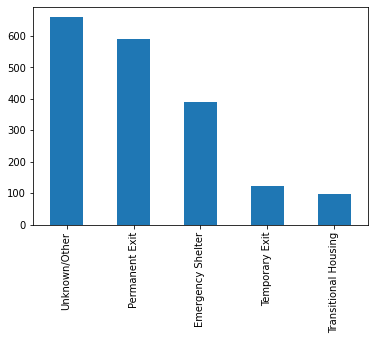

In [188]:
# Value Distribution
df_pipeline2['Target Exit Destination'].value_counts().plot(kind='bar');

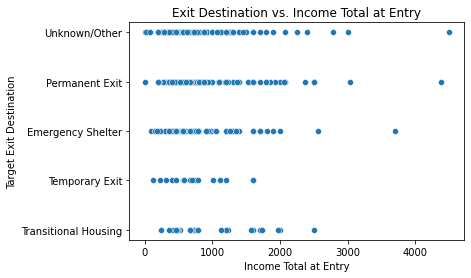

In [189]:
# Basic scatterplots
sns.scatterplot(data=df_pipeline2, y='Target Exit Destination', x='Income Total at Entry').set_title('Exit Destination vs. Income Total at Entry');

# Feature Engineering

In [190]:
# List of income columns
income = ['Earned Income',
          'Supplemental Security Income', 
          'Social Security Disability Income', 
          'VA Disability Compensation', 
          'Private Disability Income', 
          'Workers Compensation', 
          'TANF', 
          'General Assistance' ,
          'Child Support', 
          'Other Income']


# # Write a function that calculates the sum of these columns
# dataf['Income Total'] = df.loc[income].sum(axis=1)

# Pipeline 3

In [191]:
# Pipeline 3

def start_pipeline(dataf):
    '''Creates a copy of original dataframe to use in pipeline'''
    return dataf.copy()

def income_sum(dataf):
    '''Creates a column that is the sum of each person\'s income'''
    dataf['Income Total'] = dataf.loc[income].sum(axis=1)
    return dataf


In [192]:
# Execute Pipeline 3
df_pipeline3 = (df_pipeline2
    .pipe(start_pipeline)
#     .pipe(income_sum)
)

In [193]:
print(df_pipeline3.shape)
df_pipeline3.head()

(1862, 70)


,Project Name,Relationship to HoH,CaseMembers,Enroll Date,Exit Date,Social Security Quality,Age at Enrollment,Race,Ethnicity,Gender,Veteran Status,Disabling Condition at Entry,Living Situation,Length of Stay,Homeless Start Date,Length of Time Homeless (Approximate Start),Times Homeless Last Years,Total Months Homeless Last Years,Last Permanent Address,State,Zip,Days Enrolled in Project,Housing Status,Covered by Health Insurance,Domestic Violence,Current Status (Retired Data Element),Connected to McKinney Vento Liason (Retired),Household Type,Last Grade Completed,School Status,Employed Status,Why Not Employed,Count of Bed Nights (Housing Check-ins),Date of Last ES Stay (Beta),Date of First ES Stay (Beta),Income Total at Entry,Income Total at Exit,Non-Cash Benefit Count,Non-Cash Benefit Count at Exit,Barrier Count at Entry,Under Years Old,Chronic Health Condition,Mental Health Problem,CaseChildren,CaseAdults,Other Public,State Funded,Indian Health Services (IHS),Other,Combined Childrens HealthInsurance/Medicaid,Medicaid,Medicare,State Children's health Insurance S-CHIP,Veteran's Administration Medical Services,Health Insurance obtained through COBRA,Private - Employer,Private,Private - Individual,Earned Income,Unemployment Insurance,Supplemental Security Income,Social Security Disability Income,VA Disability Compensation,Private Disability Income,Workers Compensation,TANF,General Assistance,Child Support,Other Income,Target Exit Destination
0,FPS--ES--Bridges Family Shelter,Son,6,736582,736702,Client Refused,4,White,Non-Hispanic/Latino,Male,NaN,No,NaN,Unknown,1,NaN,NaN,NaN,NaN,NaN,NaN,120,NaN,Yes,NaN,NaN,NaN,Household with Adults and Children,NaN,NaN,NaN,NaN,0,1,1,NaN,NaN,0,0,0,Yes,NaN,NaN,4,2,No,Yes,No,No,No,No,No,No,No,No,No,No,No,0.0,0,0.0,0,0,0,0,0,0,0.0,0,Unknown/Other
1,FPS--ES--Bridges Family Shelter,Self,6,736582,736702,Full SSN,28,White,Non-Hispanic/Latino,Male,No,Missing,Hotel or motel paid for without emergency shel...,"One month or more, but less than 90 days",735538,1164.0,Three times,More than 12 months,Data not collected,NaN,NaN,120,Category 1 - Homeless,Yes,NaN,NaN,NaN,Household with Adults and Children,NaN,NaN,NaN,NaN,0,1,1,1300.0,NaN,0,0,1,No,NaN,NaN,4,2,No,Yes,No,No,No,No,No,No,No,No,No,No,No,1300.0,0,0.0,0,0,0,0,0,0,0.0,0,Unknown/Other
2,FPS--ES--Bridges Family Shelter,Daughter,6,736582,736718,Client Refused,10,White,Non-Hispanic/Latino,Female,NaN,No,NaN,Unknown,1,NaN,NaN,NaN,NaN,NaN,NaN,136,NaN,Yes,NaN,NaN,NaN,Household with Adults and Children,NaN,NaN,NaN,NaN,0,1,1,NaN,NaN,0,0,0,Yes,NaN,NaN,4,2,No,Yes,No,No,No,No,No,No,No,No,No,No,No,0.0,0,0.0,0,0,0,0,0,0,0.0,0,Unknown/Other
3,FPS--ES--Bridges Family Shelter,Son,6,736582,736702,Full SSN,5,White,Non-Hispanic/Latino,Male,NaN,No,NaN,Unknown,1,NaN,NaN,NaN,NaN,NaN,NaN,120,Category 1 - Homeless,Yes,NaN,NaN,NaN,Household with Adults and Children,NaN,NaN,NaN,NaN,0,1,1,NaN,NaN,0,0,0,Yes,NaN,NaN,4,2,No,Yes,No,No,No,No,No,No,No,No,No,No,No,0.0,0,0.0,0,0,0,0,0,0,0.0,0,Unknown/Other
4,FPS--ES--Bridges Family Shelter,Significant Other (Non-Married),6,736582,736702,Client Refused,27,White,Non-Hispanic/Latino,Female,No,Yes,Hotel or motel paid for without emergency shel...,Unknown,736212,490.0,NaN,More than 12 months,NaN,NaN,NaN,120,Category 1 - Homeless,Yes,NaN,NaN,NaN,Household with Adults and Children,NaN,NaN,NaN,NaN,0,1,1,1200.0,1600.0,1,0,2,No,NaN,Mental Illness,4,2,No,Yes,No,No,No,No,No,No,No,No,No,No,No,1200.0,0,0.0,0,0,0,0,0,0,0.0,0,Unknown/Other


# Feature Selection

In [194]:
# features = ['CaseMembers','Race', 'Ethnicity', 
#             'Current Age', 'Gender', 'Length of Stay', 
#             'Days Enrolled in Project','Household Type', 
#             'Barrier Count at Entry']

In [195]:
target = 'Target Exit Destination'

In [196]:
X = df_pipeline3.drop(columns=[target])
y = df_pipeline3[target]

# Baseline

In [197]:
y.value_counts(normalize=True)

Unknown/Other           0.353921
Permanent Exit          0.317938
Emergency Shelter       0.209989
Temporary Exit          0.066058
Transitional Housing    0.052095
Name: Target Exit Destination, dtype: float64

# Data Split

In [198]:
# Train, Test, Validation Split

# First split : Train, Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split : Train, Val
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Modeling

Modeling Strategy: 
- Implement SKL pipeline to add modularity to workflow
- Begin with random forest implementation
- Update model choices using combinations of cross-validation, loss metrics, hyperparameter tuning

In [199]:
# Pipeline for random forest model
random_forest_model = Pipeline([('ord', OrdinalEncoder()),
                                ('imputer', SimpleImputer()),
                                ('classifier', RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42, verbose=1))])


In [200]:
# Fit the model
random_forest_model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.1s finished


Pipeline(steps=[('ord',
                 OrdinalEncoder(cols=['Project Name', 'Relationship to HoH',
                                      'Social Security Quality', 'Race',
                                      'Ethnicity', 'Gender', 'Veteran Status',
                                      'Disabling Condition at Entry',
                                      'Living Situation', 'Length of Stay',
                                      'Times Homeless Last Years',
                                      'Total Months Homeless Last Years',
                                      'Last Permanent Address', 'State',
                                      'Housing Status',
                                      'Covered by Health Insurance',
                                      'Domestic Viol...
                                          'data_type': dtype('O'),
                                          'mapping': No     1
NaN    2
dtype: int64},
                                         {'col': 'Sta

In [201]:
print("Validation: ", random_forest_model.score(X_val, y_val))
print("Test: ", random_forest_model.score(X_test, y_test))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s


Validation:  0.7024128686327078
Test:  0.7184986595174263


[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.3s finished


In [202]:
# Setup for classification report metrics
y_true = y_val
y_pred = random_forest_model.predict(X_val)
target_names = ['Permanent Exit', 'Temporary Exit', 'Transitional Housing', 'Emergency Shelter' , 'Unknown/Other']

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.4s finished


In [203]:
print(classification_report(y_true, y_pred, target_names=target_names))

                      precision    recall  f1-score   support

      Permanent Exit       0.74      0.47      0.58        85
      Temporary Exit       0.70      0.77      0.73       127
Transitional Housing       0.86      0.38      0.52        16
   Emergency Shelter       0.92      0.46      0.61        24
       Unknown/Other       0.67      0.88      0.76       121

            accuracy                           0.70       373
           macro avg       0.78      0.59      0.64       373
        weighted avg       0.72      0.70      0.69       373



# Modeling Serialization


In [204]:
# Extract the classifier step from the pipeline
clf = random_forest_model['classifier']
joblib_file = "randomforest_modelv1.pkl"
joblib.dump(clf, joblib_file)

['randomforest_modelv1.pkl']

In [209]:
joblib.dump(random_forest_model, "randomforest_model.joblib", compress=True)

['randomforest_model.joblib']

In [ ]:
# df_pipeline3.to_csv("../All_data_with_exits_cleaned.csv", index=False)

# Reading the files

In [215]:
model_pkl = pd.read_pickle(r'randomforest_modelv1.pkl')

In [216]:
model_pkl

array(['Emergency Shelter', 'Permanent Exit', 'Temporary Exit',
       'Transitional Housing', 'Unknown/Other'], dtype=object)

In [218]:
model_job = joblib.load('randomforest_model.joblib')

In [219]:
model_job

Pipeline(steps=[('ord',
                 OrdinalEncoder(cols=['Project Name', 'Relationship to HoH',
                                      'Social Security Quality', 'Race',
                                      'Ethnicity', 'Gender', 'Veteran Status',
                                      'Disabling Condition at Entry',
                                      'Living Situation', 'Length of Stay',
                                      'Times Homeless Last Years',
                                      'Total Months Homeless Last Years',
                                      'Last Permanent Address', 'State',
                                      'Housing Status',
                                      'Covered by Health Insurance',
                                      'Domestic Viol...
                                          'data_type': dtype('O'),
                                          'mapping': No     1
NaN    2
dtype: int64},
                                         {'col': 'Sta

# Visualizations

In [165]:
import streamlit as st

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as ple
import shap
from pdpbox.pdp import pdp_isolate, pdp_plot

In [166]:
df_pipeline3.head()

,Project Name,Relationship to HoH,CaseMembers,Enroll Date,Exit Date,Social Security Quality,Age at Enrollment,Race,Ethnicity,Gender,Veteran Status,Disabling Condition at Entry,Living Situation,Length of Stay,Homeless Start Date,Length of Time Homeless (Approximate Start),Times Homeless Last Years,Total Months Homeless Last Years,Last Permanent Address,State,Zip,Days Enrolled in Project,Housing Status,Covered by Health Insurance,Domestic Violence,Current Status (Retired Data Element),Connected to McKinney Vento Liason (Retired),Household Type,Last Grade Completed,School Status,Employed Status,Why Not Employed,Count of Bed Nights (Housing Check-ins),Date of Last ES Stay (Beta),Date of First ES Stay (Beta),Income Total at Entry,Income Total at Exit,Non-Cash Benefit Count,Non-Cash Benefit Count at Exit,Barrier Count at Entry,Under Years Old,Chronic Health Condition,Mental Health Problem,CaseChildren,CaseAdults,Other Public,State Funded,Indian Health Services (IHS),Other,Combined Childrens HealthInsurance/Medicaid,Medicaid,Medicare,State Children's health Insurance S-CHIP,Veteran's Administration Medical Services,Health Insurance obtained through COBRA,Private - Employer,Private,Private - Individual,Earned Income,Unemployment Insurance,Supplemental Security Income,Social Security Disability Income,VA Disability Compensation,Private Disability Income,Workers Compensation,TANF,General Assistance,Child Support,Other Income,Target Exit Destination
0,FPS--ES--Bridges Family Shelter,Son,6,736582,736702,Client Refused,4,White,Non-Hispanic/Latino,Male,NaN,No,NaN,Unknown,1,NaN,NaN,NaN,NaN,NaN,NaN,120,NaN,Yes,NaN,NaN,NaN,Household with Adults and Children,NaN,NaN,NaN,NaN,0,1,1,NaN,NaN,0,0,0,Yes,NaN,NaN,4,2,No,Yes,No,No,No,No,No,No,No,No,No,No,No,0.0,0,0.0,0,0,0,0,0,0,0.0,0,Unknown/Other
1,FPS--ES--Bridges Family Shelter,Self,6,736582,736702,Full SSN,28,White,Non-Hispanic/Latino,Male,No,Missing,Hotel or motel paid for without emergency shel...,"One month or more, but less than 90 days",735538,1164.0,Three times,More than 12 months,Data not collected,NaN,NaN,120,Category 1 - Homeless,Yes,NaN,NaN,NaN,Household with Adults and Children,NaN,NaN,NaN,NaN,0,1,1,1300.0,NaN,0,0,1,No,NaN,NaN,4,2,No,Yes,No,No,No,No,No,No,No,No,No,No,No,1300.0,0,0.0,0,0,0,0,0,0,0.0,0,Unknown/Other
2,FPS--ES--Bridges Family Shelter,Daughter,6,736582,736718,Client Refused,10,White,Non-Hispanic/Latino,Female,NaN,No,NaN,Unknown,1,NaN,NaN,NaN,NaN,NaN,NaN,136,NaN,Yes,NaN,NaN,NaN,Household with Adults and Children,NaN,NaN,NaN,NaN,0,1,1,NaN,NaN,0,0,0,Yes,NaN,NaN,4,2,No,Yes,No,No,No,No,No,No,No,No,No,No,No,0.0,0,0.0,0,0,0,0,0,0,0.0,0,Unknown/Other
3,FPS--ES--Bridges Family Shelter,Son,6,736582,736702,Full SSN,5,White,Non-Hispanic/Latino,Male,NaN,No,NaN,Unknown,1,NaN,NaN,NaN,NaN,NaN,NaN,120,Category 1 - Homeless,Yes,NaN,NaN,NaN,Household with Adults and Children,NaN,NaN,NaN,NaN,0,1,1,NaN,NaN,0,0,0,Yes,NaN,NaN,4,2,No,Yes,No,No,No,No,No,No,No,No,No,No,No,0.0,0,0.0,0,0,0,0,0,0,0.0,0,Unknown/Other
4,FPS--ES--Bridges Family Shelter,Significant Other (Non-Married),6,736582,736702,Client Refused,27,White,Non-Hispanic/Latino,Female,No,Yes,Hotel or motel paid for without emergency shel...,Unknown,736212,490.0,NaN,More than 12 months,NaN,NaN,NaN,120,Category 1 - Homeless,Yes,NaN,NaN,NaN,Household with Adults and Children,NaN,NaN,NaN,NaN,0,1,1,1200.0,1600.0,1,0,2,No,NaN,Mental Illness,4,2,No,Yes,No,No,No,No,No,No,No,No,No,No,No,1200.0,0,0.0,0,0,0,0,0,0,0.0,0,Unknown/Other


In [220]:
feature = "CaseMembers"

isolated = pdp_isolate(
    model=model_job,
    dataset=X_val,
    model_features=X_val.columns,
    feature = feature
)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elaps

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <AxesSubplot:>,
  'pdp_ax': <AxesSubplot:xlabel='CaseMembers (class 0)'>})

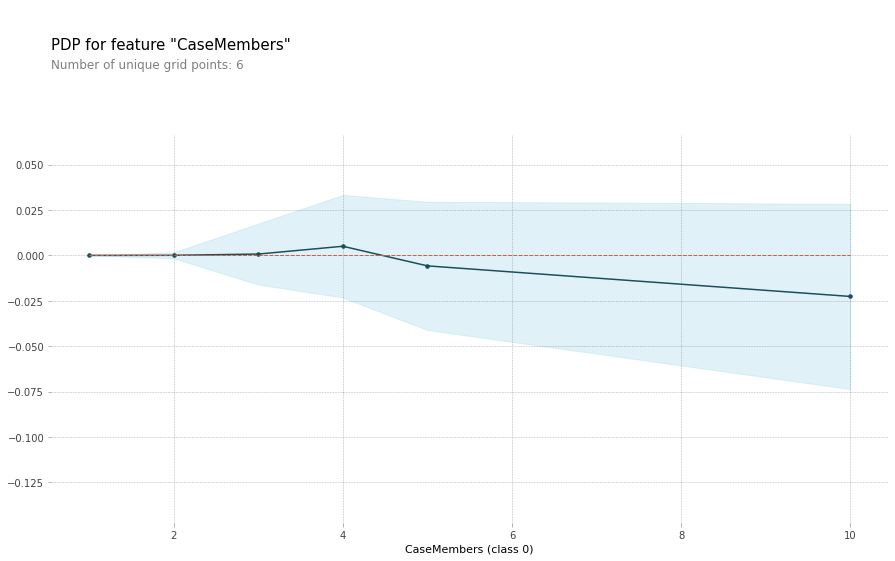

In [223]:
pdp_plot(isolated[:1], feature_name=feature)

In [222]:
isolated